In [15]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
# Read data from CSV file
df = pd.read_csv("ACB.VN.csv")
df.dropna(inplace=True)

In [17]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

# Select 'Close' column
data = df['Close'].values

In [18]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Define the size of train and test set
train_size = int(len(data_scaled) * 0.9)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data, sequence_length)




In [19]:
# Reshape input data for RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# Predict Close price for the next 30, 60, 90 days
def predict_next_days(n_days, model, last_sequence):
    y_next_days = []
    for i in range(n_days):
        next_day_pred = model.predict(last_sequence)
        y_next_days.append(next_day_pred[0][0])
        last_sequence = np.concatenate([last_sequence[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)
    return scaler.inverse_transform(np.array(y_next_days).reshape(-1, 1))

last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)

y_next_30_days = predict_next_days(30, model, last_sequence_days)
y_next_60_days = predict_next_days(60, model, last_sequence_days)
y_next_90_days = predict_next_days(90, model, last_sequence_days)



Epoch 1/50
36/36 - 2s - loss: 0.0147 - val_loss: 0.0192 - 2s/epoch - 50ms/step
Epoch 2/50
36/36 - 1s - loss: 0.0021 - val_loss: 0.0114 - 628ms/epoch - 17ms/step
Epoch 3/50
36/36 - 1s - loss: 0.0016 - val_loss: 0.0062 - 629ms/epoch - 17ms/step
Epoch 4/50
36/36 - 1s - loss: 0.0013 - val_loss: 0.0092 - 605ms/epoch - 17ms/step
Epoch 5/50
36/36 - 1s - loss: 0.0012 - val_loss: 0.0042 - 640ms/epoch - 18ms/step
Epoch 6/50
36/36 - 1s - loss: 9.7615e-04 - val_loss: 0.0022 - 660ms/epoch - 18ms/step
Epoch 7/50
36/36 - 0s - loss: 9.5589e-04 - val_loss: 0.0031 - 395ms/epoch - 11ms/step
Epoch 8/50
36/36 - 0s - loss: 8.8872e-04 - val_loss: 0.0021 - 388ms/epoch - 11ms/step
Epoch 9/50
36/36 - 0s - loss: 7.4537e-04 - val_loss: 0.0039 - 372ms/epoch - 10ms/step
Epoch 10/50
36/36 - 0s - loss: 7.4240e-04 - val_loss: 0.0018 - 376ms/epoch - 10ms/step
Epoch 11/50
36/36 - 0s - loss: 7.5170e-04 - val_loss: 0.0032 - 371ms/epoch - 10ms/step
Epoch 12/50
36/36 - 0s - loss: 6.7675e-04 - val_loss: 0.0035 - 382ms/epoch 

In [20]:
# Evaluate model
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error,mean_absolute_error

# Predictions on test set
y_pred_test = model.predict(X_test)
y_pred_91=scaler.inverse_transform(y_pred_test)
# Calculate test metrics
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_91)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_91)

print(f"MAPE on Test set: {test_mape}")
print(f"RMSE on Test set: {test_rmse}")
print(f"MAE on Test set: {test_mae}")

3/3 [==============================] - 0s 6ms/step
MAPE on Test set: 0.03027705978176043
RMSE on Test set: 23590.51185529883
MAE on Test set: 23585.40594418416


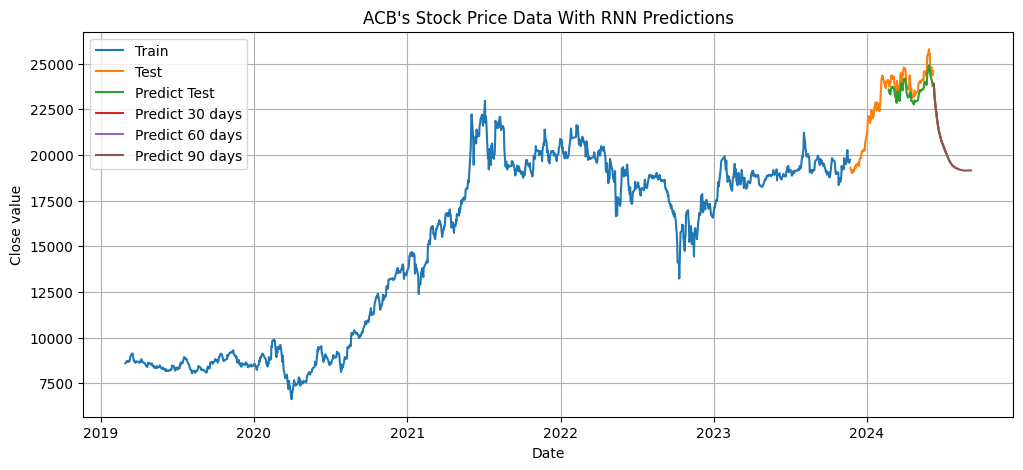

In [21]:
# Plotting
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

# Test set
plt.plot(df.index[train_size:train_size + len(test_data)], scaler.inverse_transform(test_data))

# Predictions on test set
test_pred_index = df.index[train_size + sequence_length - 1:train_size + len(y_test) + sequence_length - 1]
plt.plot(test_pred_index, scaler.inverse_transform(y_pred_test))

# Predictions for the next 30, 60, 90 days
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30)
index_next_60_days = pd.date_range(start=next_date, periods=60)
index_next_90_days = pd.date_range(start=next_date, periods=90)

plt.plot(index_next_30_days, y_next_30_days, label="Next 30 days")
plt.plot(index_next_60_days, y_next_60_days, label="Next 60 days")
plt.plot(index_next_90_days, y_next_90_days, label="Next 90 days")

plt.legend(['Train', 'Test', 'Predict Test', 'Predict 30 days', 'Predict 60 days', 'Predict 90 days'])
plt.grid()
plt.title("ACB's Stock Price Data With RNN Predictions")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.show()